In [49]:
# Step 0: Importing Required Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Optional: For visualizing correlations or distributions
import matplotlib.pyplot as plt
import seaborn as sns


In [50]:
# Step 1: Load the dataset
df = pd.read_csv('players_data.csv')

# Display first few rows to confirm
df.head()


,userNum,nickname,gameId,seasonId,gameRank,character,weapon,itemWeapon,itemChest,itemHead,...,Trait_Main1,Trait_Main2,Trait_Sub1,Trait_Sub2,TeamKill,Kill,Death,Assist,Dmg_Player,Dmg_Monster
0,5426009,마샤,46678118,31,2,Cathy,Dagger,Asura,The_Revenant,Imperial_Crown,...,Unwavering_Mentality,Cavalcade,Coin_Toss,Penny_Pincher,5,0,3,5,12065,53392
1,5296453,쿠로미여동생,46678118,31,1,Hisui,Two-handed_Sword,Aurora_Longsword,Áo_Dài,Blaster_Helmet,...,Contempt_for_the_Weak,Anima_Reaper,Unwavering_Mentality,Cavalcade,17,5,4,7,15397,79563
2,5162955,우주생명마음,46678118,31,5,Adina,Arcana,The_Moon,Blood_Cloak,Persona,...,Open_Wounds,Overwatch,Dismantle_Goliath,Anima_Reaper,19,12,2,6,36449,67664
3,5140049,只玩过卡拉彼丘,46678118,31,7,Ly Anh,Dagger,Maharaja,Dragon_Dobok,Cowboy_Hat,...,Frenzy,Carnivore,Painkiller,Dine_n'_Dash,10,0,3,6,6315,23338
4,5051669,초고교급마다키,46678118,31,7,Tsubame,Shuriken,Petal_Torrent,Changpao,Crystal_Tiara,...,Dismantle_Goliath,Anima_Reaper,Unwavering_Mentality,Cavalcade,10,9,2,0,17556,50226


In [51]:
# Step 3: Handle missing values
missing_ratio = df.isnull().mean().sort_values(ascending=False)
print("Missing values (top 10):\n", missing_ratio.head(10))

# Drop rows where key performance metrics are missing (gameRank, Dmg_Player, etc.)
df.dropna(subset=['gameRank', 'Dmg_Player', 'Dmg_Monster','Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2'], inplace=True)


Missing values (top 10):
 Trait_Main2    0.097546
Trait_Main1    0.097546
Trait_Sub2     0.002083
Trait_Sub1     0.000577
nickname       0.000015
userNum        0.000000
Dmg_Player     0.000000
Assist         0.000000
Death          0.000000
Kill           0.000000
dtype: float64


In [52]:
# Step 4: Feature Engineering (fixed)

# Fill missing trait values with 'Unknown' and ensure everything is a string
df[['Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2']] = (
    df[['Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2']]
    .fillna('Unknown')
    .astype(str)
)

#combine the traits into one string
df['AllTraits'] = df[['Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2']].agg('_'.join, axis=1)

# Bin gameRank into performance tiers
def rank_to_tier(rank):
    if rank <= 3:
        return 'Good'
    elif rank <= 6:
        return 'Average'
    else:
        return 'Bad'

df['BuildPerformance'] = df['gameRank'].apply(rank_to_tier)


In [53]:
# Step 5: Define input features and target

# Features we'll use:
categorical_features = ['character', 'weapon', 'itemWeapon', 'itemChest', 'itemHead',
                        'itemArm', 'itemLeg', 'AllTraits']
numerical_features = ['Kill', 'Assist', 'Death', 'TeamKill', 'Dmg_Player', 'Dmg_Monster']

# Target: BuildPerformance (Good/Average/Bad)
target = 'BuildPerformance'


In [54]:
# Step 6: Split dataset
X = df[categorical_features + numerical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [55]:
# Step 7: Build Preprocessing Pipeline

# Categorical pipeline: Fill missing with 'Unknown', then one-hot encode
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Numerical pipeline: Fill missing with median, then scale
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine both pipelines
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipeline, categorical_features),
    ('num', numerical_pipeline, numerical_features)
])


In [56]:
# Step 8: Final pipeline with classifier

model_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [57]:
# Step 9: Train the model
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['character', 'weapon',
                                                   'itemWeapon', 'itemChest',
                                                   'itemHead', 'itemArm',
                                                   'itemLeg', 'AllTraits']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Kill', 'Assist', 'Death',
                                                   'TeamKill', 'Dmg_Player',
                                                   'Dmg_Monster'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

Classification Report:

              precision    recall  f1-score   support

     Average       0.61      0.67      0.64      9251
         Bad       0.72      0.60      0.66      5292
        Good       0.80      0.80      0.80      9541

    accuracy                           0.70     24084
   macro avg       0.71      0.69      0.70     24084
weighted avg       0.71      0.70      0.71     24084

Confusion Matrix:



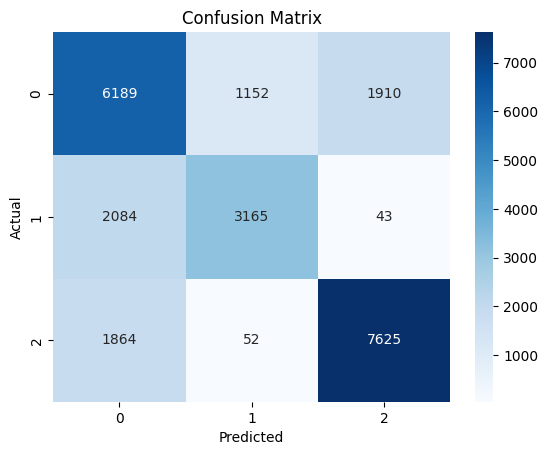

In [58]:
# Step 10: Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model_pipeline.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Predicted Average (0)	Predicted Bad (1)	Predicted Good (2)
Actual Avg (0) 1029	250	338
Actual Bad (1)	388	528	13
Actual Good (2)	340	13	1709

In [59]:
def get_recommended_build(character_name, top_n=1, display=True):

    char_data = df[df['character'] == character_name]

    if char_data.empty:
        print(f"No data found for character: {character_name}")
        return []

    top_builds = char_data[char_data['gameRank'] <= 3]

    if top_builds.empty:
        print(f"No high-performing builds found for {character_name}. Showing best available instead.")
        top_builds = char_data.sort_values(by='gameRank', ascending=True).head(top_n)
    else:
        top_builds = top_builds.sort_values(by='gameRank', ascending=True).head(top_n)

    builds = []
    for idx, (_, row) in enumerate(top_builds.iterrows(), start=1):
        build = {
            "Weapon": row['weapon'],
            "ItemWeapon": row['itemWeapon'],
            "ItemChest": row['itemChest'],
            "ItemHead": row['itemHead'],
            "ItemArm": row['itemArm'],
            "ItemLeg": row['itemLeg'],
            "Traits": [row['Trait_Main1'], row['Trait_Main2'], row['Trait_Sub1'], row['Trait_Sub2']]
        }
        builds.append(build)

        if display:
            print(f"\nRecommended Build #{idx} for {character_name}:")
            print(f"Weapon      : {build['Weapon']}")
            print(f"ItemWeapon  : {build['ItemWeapon']}")
            print(f"ItemChest   : {build['ItemChest']}")
            print(f"ItemHead    : {build['ItemHead']}")
            print(f"ItemArm     : {build['ItemArm']}")
            print(f"ItemLeg     : {build['ItemLeg']}")
            print("Traits      : " + ", ".join(build['Traits']))


In [60]:
get_recommended_build("Eva", top_n=3)



Recommended Build #1 for Eva:
Weapon      : Throw
ItemWeapon  : Chaser
ItemChest   : Couturier
ItemHead    : The_Dragon’s_Fury
ItemArm     : Pharaoh's_Artifact
ItemLeg     : Red_Shoes
Traits      : Dismantle_Goliath, Anima_Reaper, Open_Wounds, Power_Crescendo

Recommended Build #2 for Eva:
Weapon      : Throw
ItemWeapon  : Chaser
ItemChest   : Racing_Suit
ItemHead    : Fencing_Mask
ItemArm     : Necronomicon
ItemLeg     : Iron_Maiden
Traits      : Dismantle_Goliath, Anima_Reaper, Open_Wounds, Power_Crescendo

Recommended Build #3 for Eva:
Weapon      : Throw
ItemWeapon  : Incendiary_Bomb
ItemChest   : Inquisitor
ItemHead    : Chinese_Opera_Mask
ItemArm     : Dragon_Scale
ItemLeg     : Legs_of_Steel
Traits      : Stopping_Power, Overwatch, Contempt_for_the_Weak, Anima_Reaper
